In [1]:
%matplotlib inline
from intake_stac import StacCatalog, StacItem


In [13]:
#edited line 46 of ~/miniconda3/lib/python3.7/site-packages/satstac/thing.py to 
#allow for non-https url
cat  = StacCatalog('http://dev-owi.usgs.gov/stac-test/catalog.json')
#local
#cat = StacCatalog('catalog.json')


In [3]:
list(cat)

['test_netcdf']

In [4]:
list(cat['test_netcdf'])

['test_netcdf']

In [5]:
cat['test_netcdf'].metadata

{'datetime': datetime.datetime(2016, 5, 3, 13, 21, 30, 40000, tzinfo=tzutc()),
 'bbox': [-122.59750209, 37.48803556, -122.2880486, 37.613537207],
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.308150179, 37.488035566],
    [-122.597502109, 37.538869539],
    [-122.576687533, 37.613537207],
    [-122.2880486, 37.562818007],
    [-122.308150179, 37.488035566]]]},
 'date': datetime.date(2016, 5, 3),
 'catalog_dir': ''}

In [6]:
cat.items()

dict_items([('test_netcdf', name: test_netcdf
container: catalog
plugin: ['stac-item']
description: 
direct_access: True
user_parameters: []
metadata: 
args: 
  stac_obj: test_netcdf)])

In [8]:
item = cat['test_netcdf']['test_netcdf']

In [9]:
dask_netcdf = item.to_dask()

In [10]:
dask_netcdf

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 21, time: 101)
Dimensions without coordinates: lat, lon, time
Data variables:
    ppt      (time, lat, lon) float64 dask.array<shape=(101, 21, 21), chunksize=(101, 21, 21)>
Attributes:
    _NCProperties:             version=1|netcdflibversion=4.4.1|hdf5libversio...
    Conventions:               CF-1.4
    acknowledgment:            PRISM Climate Group, Oregon State University, ...
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Parameter-elevation Regressions on Independent...
    summary:                    This dataset was created using the PRISM (Par...
    keywords:                  Atmospheric Temperature, Air Temperature Atmos...
    keywords_vocabulary:       GCMD Science Keywords
    id:                        prism/thredds/cida.usgs.gov
    naming_authority:          cida.usgs.gov
    cdm_data_type:             Grid
    creator_name:              Christopher Daley
    creator_email:     

In [11]:
#get single timestep
timestep = dask_netcdf[dict(time = 100)].to_array()
#timestep.sel('tasmin_ACCESS1-3_r1i1p1_rcp45')

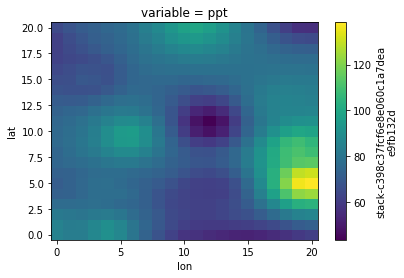

In [12]:
import matplotlib.pyplot as plt
timestep.plot()